Data Description
The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

Columns in historical_data.csv
Time features

market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer
Store features

store_id: an id representing the restaurant the order was submitted for
store_primary_category: cuisine category of the restaurant, e.g., italian, asian
order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol
Order features

total_items: total number of items in the order
subtotal: total value of the order submitted (in cents)
num_distinct_items: number of distinct items included in the order
min_item_price: price of the item with the least cost in the order (in cents)
max_item_price: price of the item with the highest cost in the order (in cents)
Market features

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.
Predictions from other models

We have predictions from other models for various stages of delivery process that we can use:

estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)
Practicalities
Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

model(s) used,
how you evaluated your model performance on the historical data,
any data processing you performed on the data,
feature engineering choices you made,
other information you would like to share your modeling approach.
We expect the project to take 3-5 hours in total, but feel free to spend as much time as you like on it. Feel free to use any open source packages for the task.

In [9]:
# Data manipulation
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [7]:
import pandas as pd

# Assuming you have a large DataFrame
df = pd.read_csv('historical_data.csv')

# Displaying only the first 10 rows to avoid excessive output
print(df.head(10))  # or df.tail(10)


   market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   
5        3.0  2015-01-28 20:30:38  2015-01-28 21:08:58      5477   
6        3.0  2015-01-31 02:16:36  2015-01-31 02:43:00      5477   
7        3.0  2015-02-12 03:03:35  2015-02-12 03:36:20      5477   
8        2.0  2015-02-16 00:11:35  2015-02-16 00:38:01      5477   
9        3.0  2015-02-18 01:15:45  2015-02-18 02:08:57      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0          

In [58]:
## Cleansing
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with a placeholder value ('Unknown')
categorical_cols = df.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='constant', fill_value='Unknown')
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

# Drop duplicate rows (if applicable)
df = df.drop_duplicates()


In [59]:
data=df
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour,dayofweek,month
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845.0,american,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,22,4,2
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477.0,mexican,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,21,1,2
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477.0,Unknown,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,20,3,1
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477.0,Unknown,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,21,1,2
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477.0,Unknown,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,2,6,2


In [60]:
# Feature Engineering

# Extract datetime features (if you have a timestamp column)
data['created_at'] = pd.to_datetime(data['created_at'])
data['hour'] = data['created_at'].dt.hour
data['dayofweek'] = data['created_at'].dt.dayofweek
data['month'] = data['created_at'].dt.month

# Convert categorical columns using one-hot encoding if necessary
# One-hot encoding only selected categorical columns (e.g., 'store_primary_category')
# One-hot encoding only selected categorical columns (e.g., 'store_primary_category')
data = pd.get_dummies(data, columns=['store_primary_category'], drop_first=True)
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], errors='coerce')
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')


# Calculate the delivery duration (difference between actual_delivery_time and created_at)
data['delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()



# Example: Create an interaction term between two features
data.drop(columns=['min_item_price','max_item_price'], inplace=True)

data.head()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,...,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845.0,1.0,4.0,3441.0,4.0,33.0,14.0,...,False,False,False,False,False,False,False,False,False,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477.0,2.0,1.0,1900.0,1.0,1.0,2.0,...,False,False,False,False,False,False,False,False,False,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477.0,1.0,1.0,1900.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477.0,1.0,6.0,6900.0,5.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477.0,1.0,3.0,3900.0,3.0,6.0,6.0,...,False,False,False,False,False,False,False,False,False,2390.0


In [61]:
# Feature scaling (Standardization)
scaler = StandardScaler()
numerical_cols_scaled = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols_scaled] = scaler.fit_transform(data[numerical_cols_scaled])

In [70]:
# Define the target and feature variables
X = data.drop(columns=['actual_delivery_time', 'created_at'])  # drop target column and any non-predictor features
y = data['actual_delivery_time'] - data['created_at']  # The target variable you want to predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Drop rows with any missing values in X_train
X_train_dropped = X_train.dropna()
X_test = X_test.dropna()

# Drop the corresponding rows in y_train
y_train_dropped = y_train[X_train_dropped.index]
y_test = y_test[X_test.index]

### Model 1 - RF

In [73]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_dropped, y_train_dropped)

# Predicting on the test set
y_pred_rf = rf_model.predict(X_test)
y_test = y_test.dt.total_seconds()
y_pred_rf = y_pred_rf.astype(float)
# Evaluate model
print(f'Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}')
print(f'Random Forest R2 Score: {r2_score(y_test, y_pred_rf)}')


Random Forest RMSE: 3338136112697.6753
Random Forest R2 Score: -2.763544612042229e+18


### Model 2 - KNN

In [74]:
# Initialize and train the model
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_dropped, y_train_dropped)

# Predicting on the test set
y_pred_knn = knn_model.predict(X_test)
y_pred_knn = y_pred_knn.astype(float)
# Evaluate model
print(f'KNN RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn))}')
print(f'KNN R2 Score: {r2_score(y_test, y_pred_knn)}')


KNN RMSE: 2986705150004.7373
KNN R2 Score: -2.2122953131200292e+18


### Hypertuning RF

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3),
    'max_features': [ 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=20, cv=3, n_jobs=-1, verbose=2, 
                                   scoring='neg_mean_squared_error', random_state=42)

# Fit the model to the data
random_search.fit(X_train_dropped, y_train_dropped)

# Print the best parameters and best score
print(f"Best parameters for RF (RandomizedSearchCV): {random_search.best_params_}")
print(f"Best score (neg MSE) for RF: {random_search.best_score_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\xqq_r\anaconda3\envs\leon_new\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best parameters for RF (RandomizedSearchCV): {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Best score (neg MSE) for RF: nan


In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get the best model from the random search
best_rf_model = random_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculate the R² score
r2 = r2_score(y_test, y_pred_rf)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Calculate the MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"R²: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


R²: -3.104035863311669e+18
RMSE: 3537807239919.312
MAE: 2878245179998.288


In [77]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Graph1: DIstribution of Delivery Duration

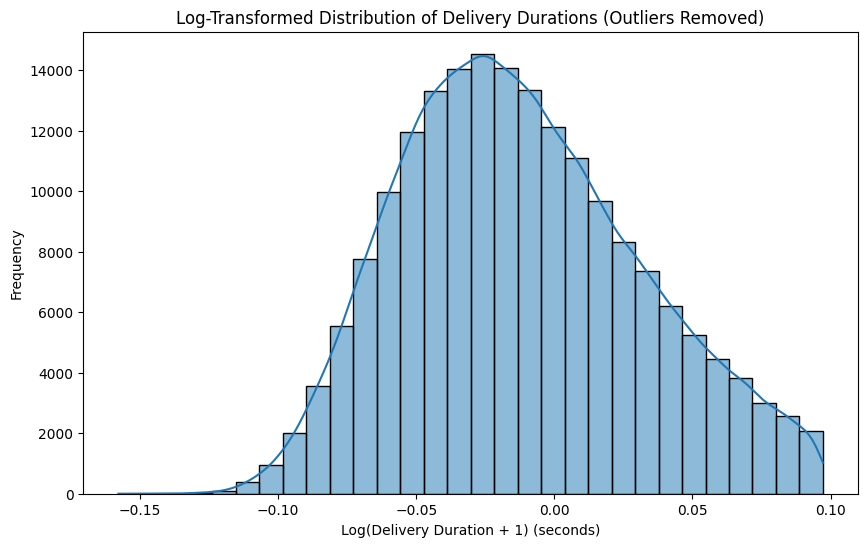

In [81]:
import numpy as np

# Define a threshold (e.g., 95th percentile) to filter out extreme values
threshold = data['delivery_duration'].quantile(0.95)

# Filter the data to remove delivery durations greater than the threshold
filtered_data = data[data['delivery_duration'] <= threshold]

# Plot the histogram of the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['log_delivery_duration'], kde=True, bins=30)
plt.title('Log-Transformed Distribution of Delivery Durations (Outliers Removed)')
plt.xlabel('Log(Delivery Duration + 1) (seconds)')
plt.ylabel('Frequency')
plt.show()


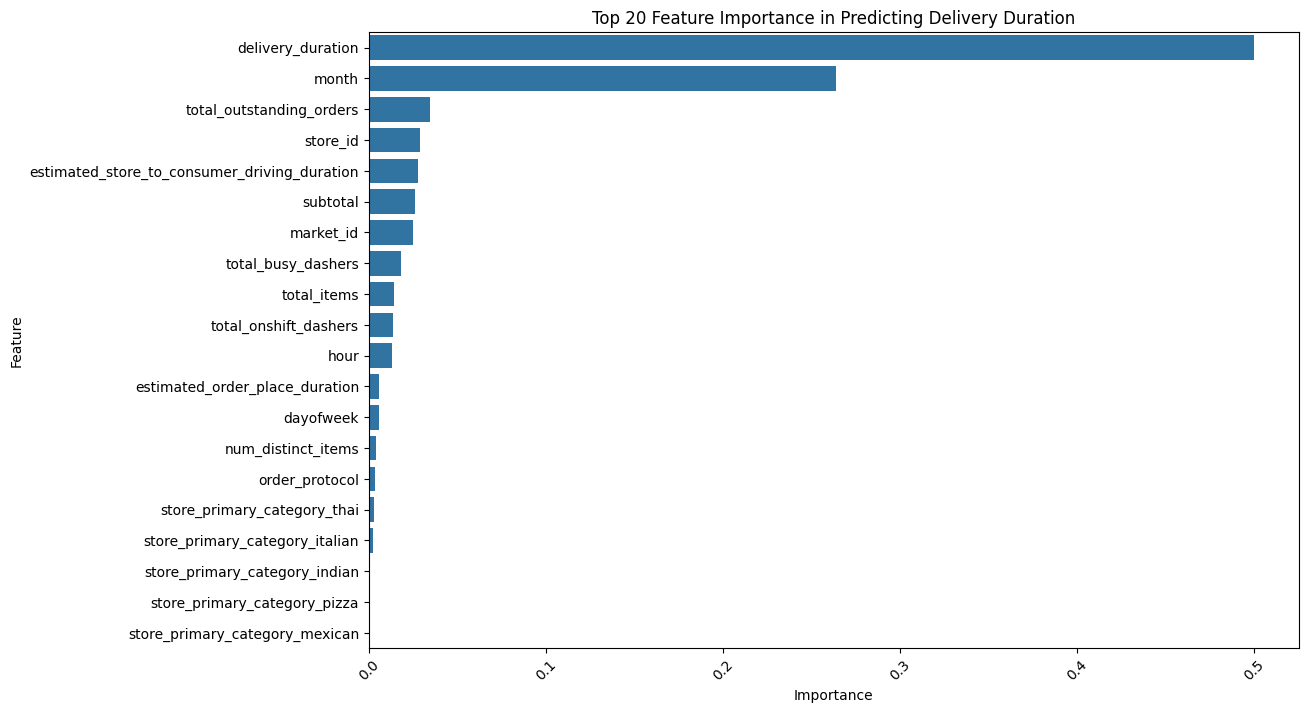

In [86]:
# Assuming you have a trained RandomizedSearchCV model, you can access the best model as:
best_rf_model = random_search.best_estimator_

# Now, you can access the feature importances
importances = best_rf_model.feature_importances_

# Get the feature names (if you have the features in X_train)
features = X_train.columns

# Create a DataFrame to hold the feature importance data
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Sort the DataFrame by importance and get top N features
top_n = 20  # Display top 20 most important features
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(top_n)

# Plot the top N important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 20 Feature Importance in Predicting Delivery Duration')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45)
plt.show()


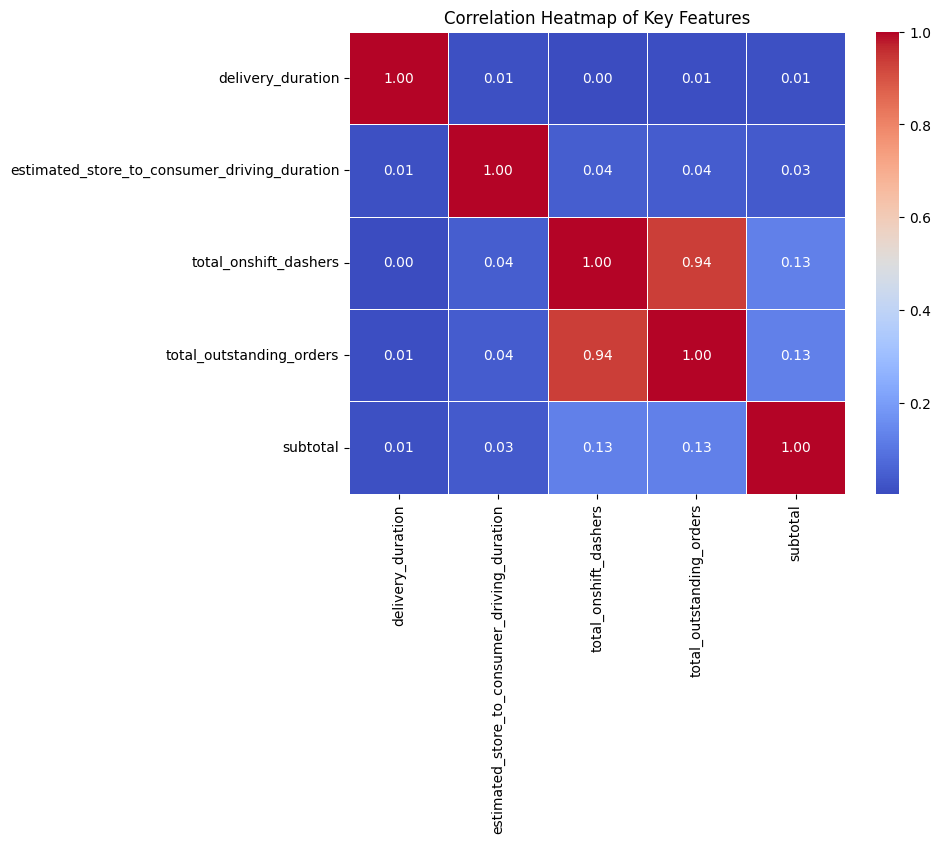

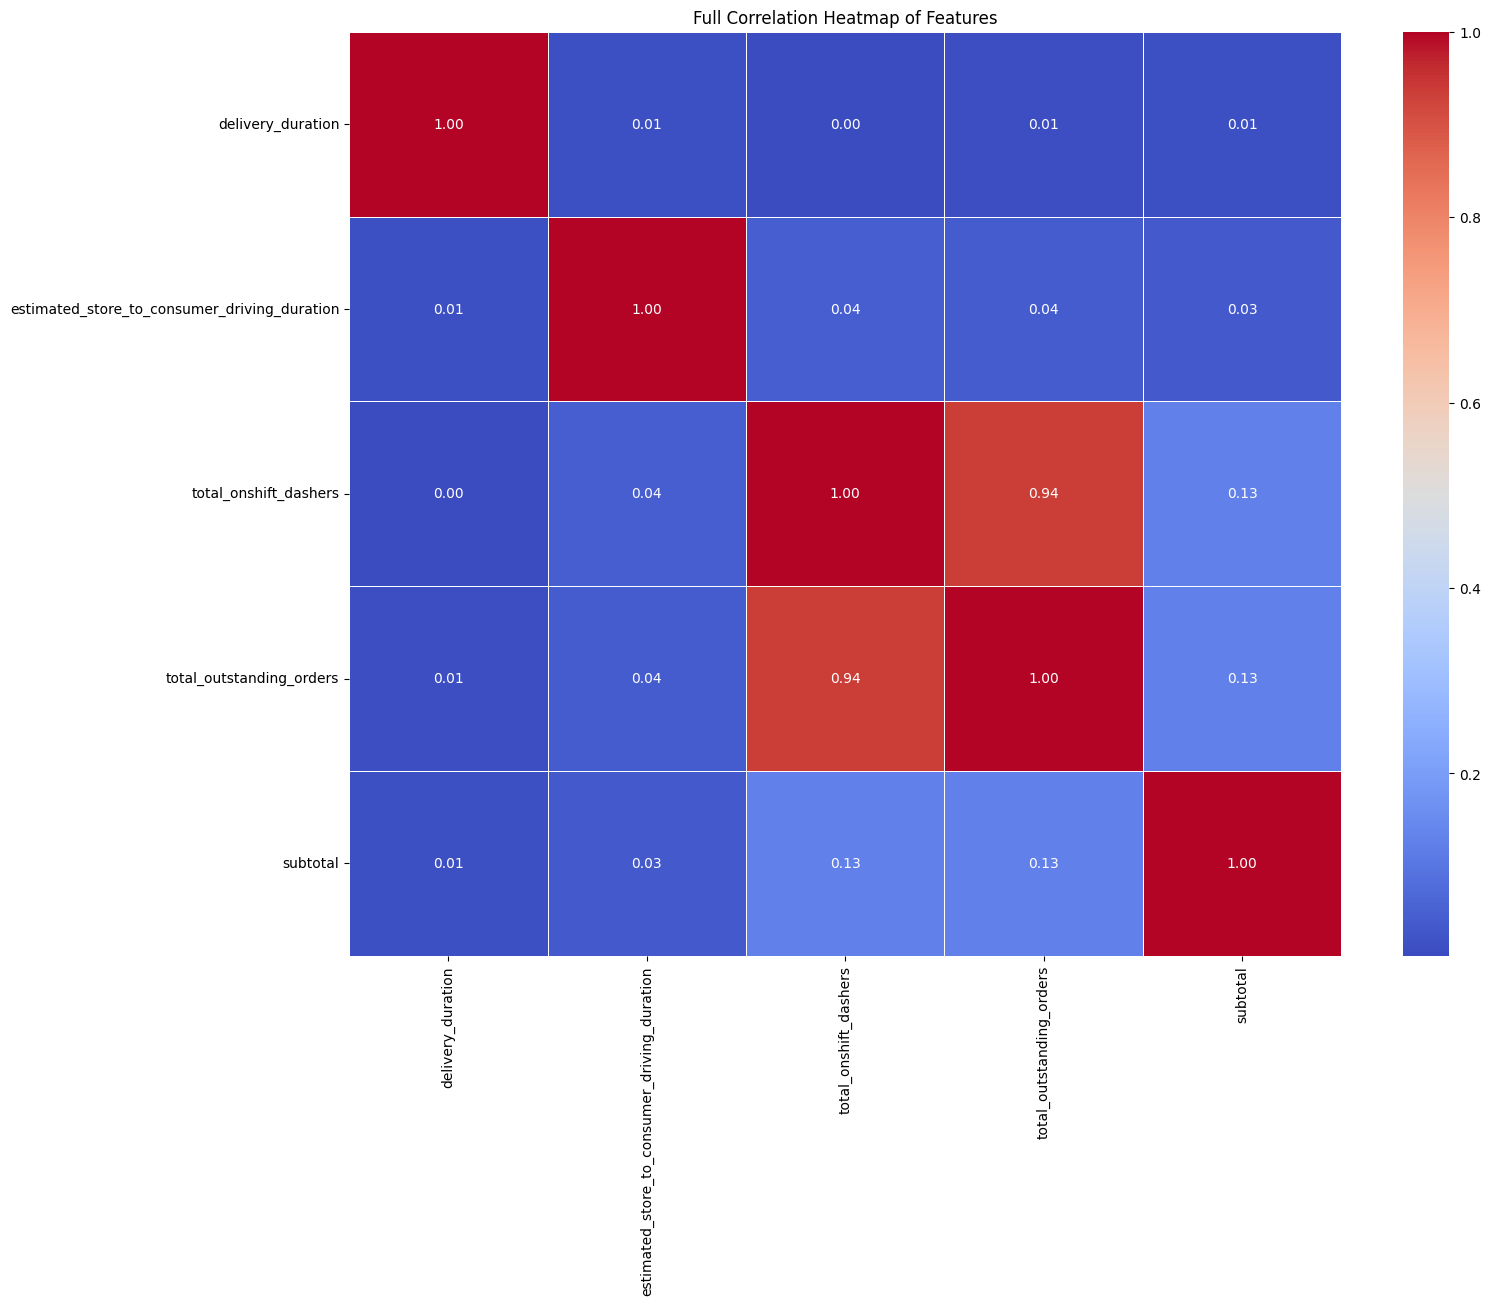

In [88]:
# Calculate the correlation matrix
corr_matrix = data[['delivery_duration', 'estimated_store_to_consumer_driving_duration', 
                     'total_onshift_dashers', 'total_outstanding_orders', 'subtotal']].corr()

# Plot the correlation heatmap for a smaller subset
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Key Features')
plt.show()
# Plot the full correlation heatmap with a larger figure
plt.figure(figsize=(16, 12))  # Increase the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Full Correlation Heatmap of Features')
plt.show()


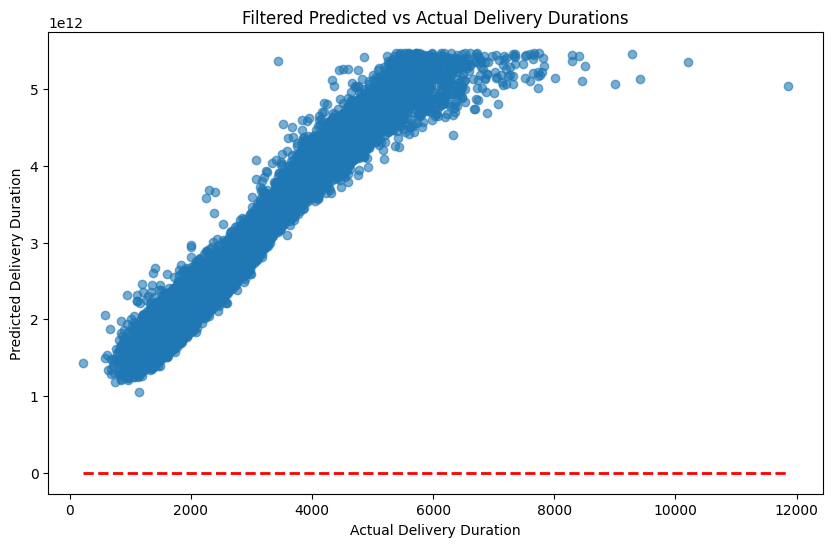

In [92]:
# Predict the delivery durations on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Define a threshold (e.g., 99th percentile) to filter out extreme values
threshold = np.percentile(y_pred_rf, 99)

# Filter the data to remove predictions above the threshold
filtered_y_test = y_test[y_pred_rf <= threshold]
filtered_y_pred_rf = y_pred_rf[y_pred_rf <= threshold]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_test, filtered_y_pred_rf, alpha=0.6)
plt.plot([filtered_y_test.min(), filtered_y_test.max()], [filtered_y_test.min(), filtered_y_test.max()], '--r', lw=2)
plt.title('Filtered Predicted vs Actual Delivery Durations')
plt.xlabel('Actual Delivery Duration')
plt.ylabel('Predicted Delivery Duration')
plt.show()

